**Bert model op basis van Bert van Universiteit van Groningen. Context handling moet nog aangepast worden. Oversampling a.d.h.v de mediaan. dynamisch treshhold zoeken voor unknown.**

In [2]:
import pandas as pd
import re
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import RandomOverSampler
import torch.nn.functional as F
import os 

In [2]:
# ✅ 1. Load & Preprocess Data
script_dir = os.getcwd() # Ga één map omhoog om 'baseline' te verwijderen en ga naar 'Data'
project_root = os.path.dirname(script_dir)  # Dit verwijdert 'baseline' van het script_dir
data_folder = os.path.join(project_root, "Data")

# 1. Dataset inladen
file_path = os.path.join(data_folder, "Grote_data.xlsx")
df = pd.read_excel(file_path)

In [3]:
# Drop unnecessary columns
if "TXT_file_name" in df.columns:
    df = df.drop(columns=["TXT_file_name"])

# Handle missing values
df = df.dropna(subset=["question"])
df["context"].fillna("", inplace=True)

# ✅ 2. Define Dutch Stopwords & Cleaning Function
dutch_stopwords = {"de", "het", "een", "en", "van", "ik", "te", "dat", "die", "in", "je", "is",
                   "niet", "op", "aan", "met", "als", "voor", "zijn", "was", "heeft", "heb",
                   "om", "bij", "of", "geen", "dan", "toch", "maar", "wel", "meer", "doen",
                   "ook", "kan", "mijn", "zo", "dus", "zou", "kunnen"}

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\b[a-z]\)\s+', ' ', text)  # Remove enumerations
    text = re.sub(r'\b\d+\.\b', '', text)  # Remove numbered lists
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = " ".join([word for word in text.split() if word not in dutch_stopwords])
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ✅ 3. Merge Context + Question & Apply Cleaning
df["clean_text"] = (df["context"] + " " + df["question"]).apply(clean_text)

# ✅ 4. Encode Theme Labels as Numbers
unique_themes = list(df["theme"].unique())
theme_to_id = {theme: idx for idx, theme in enumerate(unique_themes)}
id_to_theme = {idx: theme for theme, idx in theme_to_id.items()}  # ✅ Ensure mapping back from ID to theme
df["theme_id"] = df["theme"].map(theme_to_id)


C:\Users\jefva\AppData\Local\Temp\ipykernel_14676\3325372422.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["context"].fillna("", inplace=True)


In [4]:
# ✅ 5. Fix Class Imbalance with Oversampling
theme_counts = df["theme_id"].value_counts()
median_count = theme_counts.median()  # Set balancing threshold

# Oversample rare themes
sampling_strategy = {theme: int(median_count) for theme in theme_counts.index if theme_counts[theme] < median_count}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

X_resampled, y_resampled = ros.fit_resample(df[["clean_text"]], df["theme_id"])
df_resampled = pd.DataFrame({"clean_text": X_resampled["clean_text"], "theme_id": y_resampled})


C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [5]:
# ✅ 6. Split Data into Train & Test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_resampled["clean_text"].tolist(), df_resampled["theme_id"].tolist(), test_size=0.2, random_state=42, stratify=df_resampled["theme_id"]
)

# ✅ 7. Load BERT Tokenizer & Define Dataset Class
model_name = "GroNLP/bert-base-dutch-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

class ThemeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        encoding["labels"] = torch.tensor(self.labels[idx])
        return {key: val.squeeze(0) for key, val in encoding.items()}

train_dataset = ThemeDataset(train_texts, train_labels, tokenizer)
test_dataset = ThemeDataset(test_texts, test_labels, tokenizer)

In [6]:
# ✅ 8. Load BERT Model for Classification
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_themes))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# ✅ 9. Define Training Arguments (With Early Stopping)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,  
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",  # 🔥 Log only once per epoch
    fp16=True,
    load_best_model_at_end=True
)

# ✅ 10. Define Metrics for Evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=1)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ✅ 11. Train Model with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement for 2 epochs
)

trainer.train()


C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.531000,0.813119,0.787281,0.817590,0.787281,0.795011
2,0.602000,0.613924,0.836932,0.841929,0.836932,0.834906
3,0.368800,0.569464,0.851896,0.875952,0.851896,0.857185


TrainOutput(global_step=8823, training_loss=0.8339142983670166, metrics={'train_runtime': 1890.1743, 'train_samples_per_second': 37.336, 'train_steps_per_second': 4.668, 'total_flos': 1.857410849507328e+16, 'train_loss': 0.8339142983670166, 'epoch': 3.0})

In [8]:
# ✅ 13. Make Predictions (With Dynamic Confidence Threshold & Short Question Handling)
predictions = trainer.predict(test_dataset)
probabilities = F.softmax(torch.tensor(predictions.predictions), dim=1)

# ✅ Dynamically Adjust the Confidence Threshold (1st Percentile)
confidence_values = torch.max(probabilities, dim=1)[0].tolist()
dynamic_threshold = np.percentile(confidence_values, 1)  # ✅ Set threshold at the 5th percentile
print(f"Dynamic Threshold: {dynamic_threshold}")  # ✅ Print the new threshold

# ✅ Predict Themes with "Unknown" for Unclear Questions
predicted_labels = []
for i in range(len(probabilities)):
    max_prob = torch.max(probabilities[i]).item()
    pred_label = torch.argmax(probabilities[i]).item()
    question_text = test_texts[i]

    # ✅ If question is too short and lacks context, assign "Unknown"
    if len(question_text.split()) < 4:
        predicted_labels.append("Unknown")
    elif max_prob < dynamic_threshold:
        predicted_labels.append("Unknown")  # ✅ Filter out low-confidence predictions
    else:
        predicted_labels.append(id_to_theme[pred_label])  # ✅ Assign label


Dynamic Threshold: 0.12306695431470871


In [51]:
import numpy as np

# Extract the max probability for each question
confidence_values = np.array([torch.max(prob).item() for prob in probabilities])

# Get the indices of the 100 lowest confidence scores
worst_indices = np.argsort(confidence_values)[400:500]  # Sort and take the first 100

# Print the 100 worst predictions
for rank, idx in enumerate(worst_indices, start=1):
    worst_predicted_theme = predicted_labels[idx]  # Model's predicted theme
    true_theme_id = test_dataset[idx]['label']  # True label ID
    true_theme = id_to_theme[true_theme_id]  # Convert ID to theme name
    rounded_probs = [round(p, 4) for p in probabilities[idx].tolist()]

    print(f"Rank #{rank}")
    print(f"Lowest Confidence: {round(confidence_values[idx], 4)}")
    print(f"Question: {test_texts[idx]}")
    print(f"True Theme: {true_theme}")  # ✅ Print the actual theme
    print(f"Assigned Theme: {worst_predicted_theme}")  # ✅ Print model's prediction
    print(f"Probability Vector: {rounded_probs}")
    print(f"Max Probability: {round(confidence_values[idx], 4)}\n")



KeyError: 'label'

In [42]:
import numpy as np

# Define the percentile you want (e.g., 25th, 90th)
percentile_value = 0.0001#80  # Change this to any percentile you want

# Extract the max probability for each question
confidence_values = [torch.max(prob).item() for prob in probabilities]

# Calculate the chosen percentile
chosen_percentile_confidence = np.percentile(confidence_values, percentile_value)

# Find the question closest to this percentile confidence
closest_idx = min(range(len(confidence_values)), key=lambda i: abs(confidence_values[i] - chosen_percentile_confidence))

# Get the assigned theme
predicted_theme = predicted_labels[closest_idx]  # Ensure predicted_labels is your list of themes

# Print the results
print(f"{percentile_value}th Percentile Confidence: {round(chosen_percentile_confidence, 4)}")
print(f"Closest Question: {test_texts[closest_idx]}")
print(f"Assigned Theme: {predicted_theme}")  # ✅ Print the predicted theme
print(f"Probability Vector: {[round(p, 4) for p in probabilities[closest_idx].tolist()]}")
print(f"Max Probability: {round(confidence_values[closest_idx], 4)}")


0.0001th Percentile Confidence: 0.1166
Closest Question: klanttevredenheidsonderzoek bevordert evolutie aanbodgestuurde naar vraaggestuurde dienstverlening werking waarbij burgers ondernemingen overheden steeds centraal staan graag alle data excel ter beschikking stellen hoe zorgt men ervoor steekproef representatief klant er minimumresponsgraad
Assigned Theme: Unknown
Probability Vector: [0.1166, 0.0023, 0.0007, 0.0007, 0.0546, 0.0025, 0.0384, 0.0007, 0.0246, 0.1045, 0.0006, 0.001, 0.1007, 0.0244, 0.0193, 0.0783, 0.0013, 0.0149, 0.0754, 0.0363, 0.0115, 0.0173, 0.0226, 0.0211, 0.0024, 0.034, 0.0251, 0.0013, 0.0013, 0.0591, 0.0011, 0.0219, 0.0007, 0.0797, 0.0008, 0.0013, 0.0008]
Max Probability: 0.1166


In [9]:
'''
Visualize the confusion matrix
'''

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(labels, predicted_labels)

# Visualize it
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(id_to_theme.values()), yticklabels=list(id_to_theme.values()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.show()

NameError: name 'labels' is not defined

In [ ]:
# ✅ 14. Save Predictions 
output_df = pd.DataFrame({
    "Text": test_texts,
    "True_Theme": [id_to_theme[label] for label in test_labels],
    "Predicted_Theme": predicted_labels
})


output_df.to_excel("BertGroNLP-theme_classification.xlsx", index=False)
print("✅ Model Training Completed! Predictions saved.")

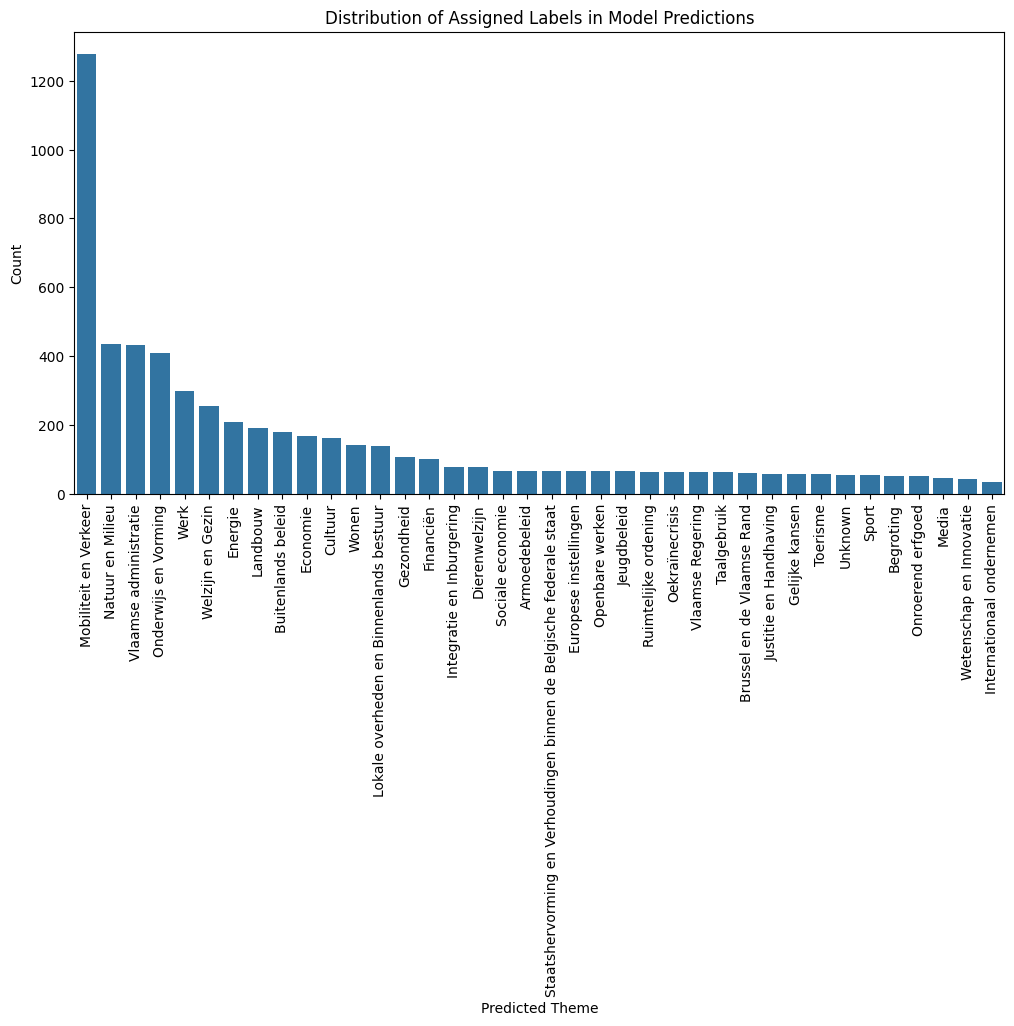

In [10]:
# ✅ 15. Visualize Distribution of Predicted Themes

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Replace this with your actual predictions DataFrame
# Example: If your predictions are stored in a variable `predicted_labels`
# Convert it into a DataFrame for visualization
df = pd.DataFrame({"Predicted_Theme": predicted_labels})

# ✅ Count occurrences of each predicted theme
label_counts = df["Predicted_Theme"].value_counts()

# ✅ Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Predicted Theme")
plt.ylabel("Count")
plt.title("Distribution of Assigned Labels in Model Predictions")
plt.show()


TO GET ATTENTION SCORES

In [11]:
import torch

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [12]:
def get_attention_and_prediction(clean_text):
    """Extracts attention scores and model prediction for a given question."""
    model.config.output_attentions = True  # Ensure attention is enabled

    # Tokenize input
    tokenizer_inputs = tokenizer(clean_text, return_tensors="pt")  
    tokenizer_inputs = {key: val.to(device) for key, val in tokenizer_inputs.items()}  # Move to GPU if available

    # Forward pass to get attention scores and logits
    with torch.no_grad():
        outputs = model(**tokenizer_inputs)

    attentions = outputs.attentions  # Extract attention scores
    logits = outputs.logits  # Model prediction scores

    predicted_class_id = logits.argmax(dim=1).item()  # Get predicted class ID
    predicted_class_name = id_to_theme.get(predicted_class_id, "Unknown")  # Convert ID to actual class name

    return attentions, predicted_class_id, predicted_class_name


test_question = "Hoeveel subsidies zijn toegekend aan bedrijven?"
attention_scores, predicted_class_id, predicted_class_name = get_attention_and_prediction(test_question)

print(f"✅ Model predicted class: {predicted_class_name} (ID: {predicted_class_id})")
print(f"🔍 Total Attention Layers Extracted: {len(attention_scores)}")

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


✅ Model predicted class: Landbouw (ID: 21)
🔍 Total Attention Layers Extracted: 12


In [13]:
import matplotlib.pyplot as plt

def visualize_attention_with_class(question):
    """Visualizes attention scores and shows the predicted class."""
    attentions, predicted_class_id, predicted_class_name = get_attention_and_prediction(question)
    
    num_layers = len(attentions)
    layer = num_layers - 1  # Last layer
    head = 0  # Choose the first attention head

    attention_matrix = attentions[layer][0, head].cpu().numpy()
    tokens = tokenizer.tokenize(question)

    plt.figure(figsize=(10, 8))
    plt.imshow(attention_matrix, cmap="viridis", aspect="auto")
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.yticks(range(len(tokens)), tokens)
    plt.colorbar(label="Attention Score")
    plt.title(f"Predicted Class: {predicted_class_name} | Attention Heatmap (Layer {layer+1}, Head {head+1})")
    plt.show()

correctly_classified_questions = []

for _, row in df.sample(100, random_state=42).iterrows():  # Test 100 random samples
    question = row["clean_text"]
    true_class = row["theme"]  # The actual correct theme

    _, predicted_class_id, predicted_class_name = get_attention_and_prediction(question)

    if predicted_class_name == true_class:  # ✅ Now we check for correct predictions
        correctly_classified_questions.append((question, true_class, predicted_class_name))

# Print first few correctly classified questions
print("✅ Correctly Classified Questions:")
for q, actual, predicted in correctly_classified_questions[:5]:
    print(f"🔍 Question: {q}")
    print(f"✅ Actual Class: {actual}")
    print(f"✅ Predicted Class: {predicted}\n")

# ✅ If there are correct predictions, visualize one
if correctly_classified_questions:
    sample_correct = correctly_classified_questions[0]  # Pick first correct prediction
    question, actual_class, predicted_class = sample_correct

    print(f"✅ Correctly Classified Example:")
    print(f"🔍 Question: {question}")
    print(f"✅ Actual Class: {actual_class}")
    print(f"✅ Predicted Class: {predicted_class}")

    # Visualize attention for correctly classified question
    visualize_attention_with_class(question)
else:
    print("❌ No correctly classified questions found in the sample!")

KeyError: 'clean_text'

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os

# ✅ 1. Load & Preprocess Data
script_dir = os.getcwd()
project_root = os.path.dirname(script_dir)

data_folder = os.path.join(project_root, "Data")
file_path = os.path.join(data_folder, "Grote_data.xlsx")
df = pd.read_excel(file_path)

# Recreate train-test split to match training
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["theme"]
)

# Combine context and question for model input
df_test["context_question"] = df_test["context"].astype(str) + " " + df_test["question"].astype(str)

# ✅ 2. Load fine-tuned model and tokenizer
model_path = "results/checkpoint-8823"  # Adjust as needed
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# ✅ 3. Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# ✅ 4. Function to get CLS embedding
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.bert(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.cpu().squeeze().numpy()

# ✅ 5. Sample and embed from test set
sample_df = df_test.sample(n=2000, random_state=42)
embeddings = []

print("Generating fine-tuned embeddings (from test set)...")
for text in tqdm(sample_df["context_question"]):
    emb = get_cls_embedding(text)
    embeddings.append(emb)

# ✅ 6. UMAP dimensionality reduction
print("Running UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# ✅ 7. Plot UMAP
le = LabelEncoder()
labels = le.fit_transform(sample_df["theme"])

plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.8)
plt.title("UMAP of GroNLP BERT Embeddings (After Fine-tuning on Test Set)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, ticks=range(len(le.classes_)), label="Theme")
plt.clim(-0.5, len(le.classes_)-0.5)
plt.grid(True)
plt.tight_layout()
plt.show()


Generating fine-tuned embeddings (from test set)...


 12%|█████████▎                                                                     | 236/2000 [00:09<01:04, 27.15it/s]